# Calculate Model Alignment

This notebook demonstrates how to calculate various alignment metrics between different neural network models/layers. The notebook showcases a methodology for quantifying representational similarities between models using several established metrics.

## Overview

The notebook demonstrates how to:

1. Calculate alignment metrics between different vision models using their activations on a shared dataset
2. Compare models using RSA (Representational Similarity Analysis), CKA (Centered Kernel Alignment), and Procrustes correlation

## Alignment Metrics

You can use any metric of your choice, including but not limited to:
- RSA (Representational Similarity Analysis)
- CKA (Centered Kernel Alignment)
- Procrustes correlation


In [ ]:
import os
import random
import json
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import MDS
from scipy.spatial import procrustes
import numpy as np
from matplotlib.gridspec import GridSpec

from thingsvision.core.cka import CKA
from thingsvision.core.rsa import compute_rdm, correlate_rdms
from itertools import combinations, product
from sklearn.decomposition import PCA

/mnt/ws/home/ssuresh/miniconda3/envs/thingsvision/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-10 17:11:30.245295: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 17:11:33.918526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-10 17:11:38.082735: I tensorflow/core/common_runtime/

2 Physical GPUs, 2 Logical GPUs


In [3]:
## Helper functions

def plot_similarity_heatmap(df, metric):
    """
    Plots a heatmap of similarity values between model layers using the specified metric.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing columns ['model1', 'layer1', 'model2', 'layer2', metric].
        metric (str): The name of the column in df containing similarity values.
    """
    print(metric)
    df["pair1"] = df["model1"] + " - " + df["layer1"]
    df["pair2"] = df["model2"] + " - " + df["layer2"]
    
    # Create a sorted list of all unique pairs
    pairs = sorted(set(df["pair1"]).union(set(df["pair2"])))
    matrix = pd.DataFrame(index=pairs, columns=pairs, dtype=float)
    
    # Fill in the metric values
    for _, row in df.iterrows():
        matrix.loc[row["pair1"], row["pair2"]] = row[metric]
        matrix.loc[row["pair2"], row["pair1"]] = row[metric]  # Symmetric
    
    # Mask upper triangle for visualization
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=0.5)
    plt.title(f"{metric} Similarity Heatmap, Average {metric}: {matrix.mean().mean():.2f}")
    plt.xlabel("Model - Layer")
    plt.ylabel("Model - Layer")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()

# Calculating similarity between models using different metrics

In [5]:
activation_dir = '../activations'
dataset_name = 'cifar100'
models = [{'model_name':'resnet50', 'source':'torchvision', 'model_parameters':None, 'layers_to_extract':['fc']},
          {'model_name':'mocov2-rn50', 'source':'ssl', 'model_parameters':None, 'layers_to_extract':['fc']},
          {'model_name':'clip', 'source':'custom', 'model_parameters':{'variant': 'ViT-B/32'}, 'layers_to_extract':['visual']},
          {'model_name':'alexnet', 'source':'torchvision', 'model_parameters':None, 'layers_to_extract':['classifier.4']}]

## RSA (Representational Similarity Analysis)

Completed 1/6 comparisons
Completed 2/6 comparisons
Completed 3/6 comparisons
Completed 4/6 comparisons
Completed 5/6 comparisons
Completed 6/6 comparisons
rsa_correlation


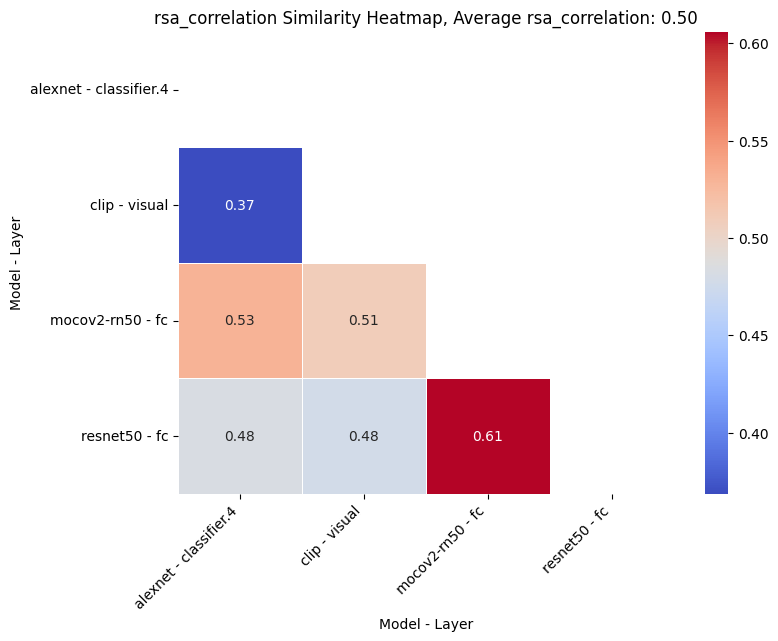

In [7]:
# RSA 
rsa_df = pd.DataFrame(columns=['model1', 'model2', 'layer1', 'layer2', 'rsa_correlation'])

# Combinations of models (no repeats)
for i, (model1, model2) in enumerate(list(combinations(models, 2))):
    # Product of layers for each model pair
    for layer1, layer2 in product(model1['layers_to_extract'], model2['layers_to_extract']):
        features_1 = np.load(f'{activation_dir}/{dataset_name}/{model1["model_name"]}/{layer1}/features.npy')
        features_2 = np.load(f'{activation_dir}/{dataset_name}/{model2["model_name"]}/{layer2}/features.npy')
        
        # Apply PCA to reduce to 20 features
        pca1 = PCA(n_components=20)
        pca2 = PCA(n_components=20)
        
        features_1_pca = pca1.fit_transform(features_1)
        features_2_pca = pca2.fit_transform(features_2)
        
        # Compute RDMs for both feature sets
        rdm1 = compute_rdm(features_1_pca, method='correlation')
        rdm2 = compute_rdm(features_2_pca, method='correlation')
        
        # Correlate the RDMs
        correlation = correlate_rdms(rdm1, rdm2, correlation='pearson')
        
        # Add to dataframe
        rsa_df.loc[len(rsa_df)] = [model1['model_name'], model2['model_name'], 
                                    layer1, layer2, correlation]
        
        print(f'Completed {i+1}/{len(list(combinations(models, 2)))} comparisons')

# Plot the results
plot_similarity_heatmap(df=rsa_df, metric='rsa_correlation')

## CKA (Centered Kernel Alignment)

Completed 1/6 comparisons
Completed 2/6 comparisons
Completed 3/6 comparisons
Completed 4/6 comparisons
Completed 5/6 comparisons
Completed 6/6 comparisons
cka


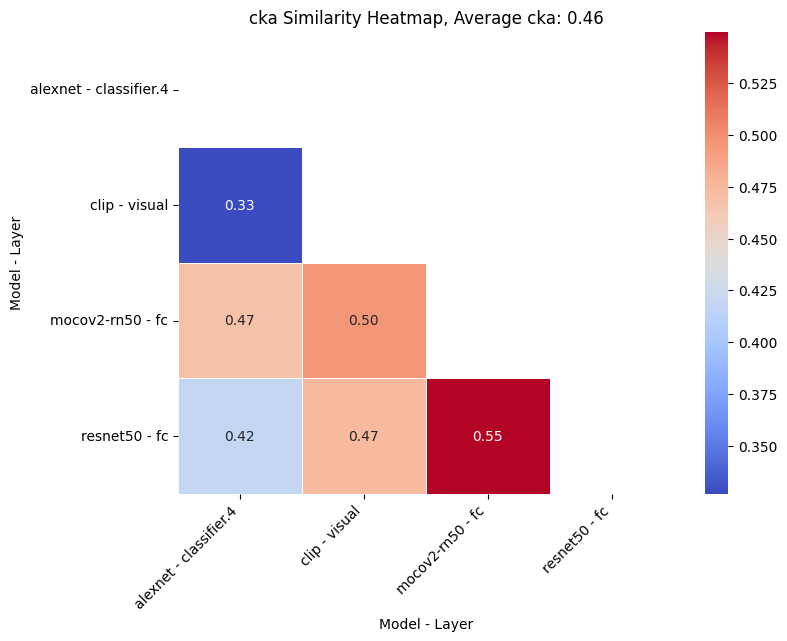

In [5]:

# cka 
cka_df = pd.DataFrame(columns=['model1', 'model2', 'layer1', 'layer2', 'cka'])
# Combinations of models (no repeats)
for i, (model1, model2) in enumerate(list(combinations(models, 2))):
    # Product of layers for each model pair
    for layer1, layer2 in product(model1['layers_to_extract'], model2['layers_to_extract']):
        features_1 = np.load(f'{activation_dir}/{dataset_name}/{model1["model_name"]}/{layer1}/features.npy')
        features_2 = np.load(f'{activation_dir}/{dataset_name}/{model2["model_name"]}/{layer2}/features.npy')
        
        # # Apply PCA to reduce to 20 features
        pca1 = PCA(n_components=20)
        pca2 = PCA(n_components=20)
        
        features_1_pca = pca1.fit_transform(features_1)
        features_2_pca = pca2.fit_transform(features_2)
        
        # # Compute RDM on PCA-reduced features
        # rdm1 = compute_rdm(features_1_pca, method='cosine')
        # rdm2 = compute_rdm(features_2_pca, method='cosine')
        # Calculate CKA
        # assert rdm1.shape == rdm2.shape
        m = features_1.shape[0]
        cka = CKA(m=m, kernel='linear')
        rho = cka.compare(X=features_1_pca, Y=features_2_pca)
        # Add to dataframe
        cka_df.loc[len(cka_df)] = [model1['model_name'], model2['model_name'], 
                                   layer1, layer2, rho]
        print(f'Completed {i+1}/{len(list(combinations(models, 2)))} comparisons')
plot_similarity_heatmap(df = cka_df, metric = 'cka')

## Procestes correlation

Completed 1/6 comparisons
Completed 2/6 comparisons
Completed 3/6 comparisons
Completed 4/6 comparisons
Completed 5/6 comparisons
Completed 6/6 comparisons
procrustes_correlation


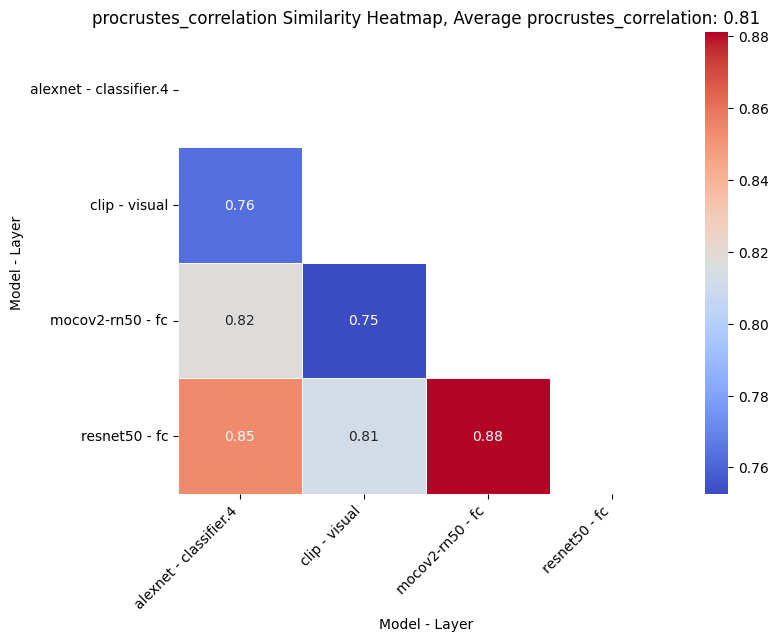

In [ ]:
# Procrustes Analysis

procrustes_df = pd.DataFrame(columns=['model1', 'model2', 'layer1', 'layer2', 'procrustes_correlation'])

# Combinations of models (no repeats)
for i, (model1, model2) in enumerate(list(combinations(models, 2))):
    # Product of layers for each model pair
    for layer1, layer2 in product(model1['layers_to_extract'], model2['layers_to_extract']):
        features_1 = np.load(f'{activation_dir}/{dataset_name}/{model1["model_name"]}/{layer1}/features.npy')
        features_2 = np.load(f'{activation_dir}/{dataset_name}/{model2["model_name"]}/{layer2}/features.npy')
        fnames = np.loadtxt(f'{activation_dir}/{dataset_name}/file_names.txt', dtype=str)
        # Extract class names from file paths
        class_names = [f.split('/')[-2] for f in fnames]
        unique_classes = np.unique(class_names)
        
        
        # Calculate mean representation for each class
        mean_features_1 = {}
        mean_features_2 = {}
        
        for class_name in unique_classes:
            class_indices = [i for i, c in enumerate(class_names) if c == class_name]
            mean_features_1[class_name] = np.mean(features_1[class_indices], axis=0)
            mean_features_2[class_name] = np.mean(features_2[class_indices], axis=0)
            
        # Convert to matrices for Procrustes analysis
        class_means_1 = np.array([mean_features_1[c] for c in unique_classes])
        class_means_2 = np.array([mean_features_2[c] for c in unique_classes])
        
        # Compute rdms
        rdm1 = compute_rdm(class_means_1, method='cosine')
        rdm2 = compute_rdm(class_means_2, method='cosine')
        
        # Compute Procrustes disparity
        _, _, disparity = procrustes(rdm1, rdm2)
        
        # Convert disparity to correlation
        correlation = np.sqrt(1 - disparity)
        
        # Add to dataframe
        procrustes_df.loc[len(procrustes_df)] = [model1['model_name'], model2['model_name'], 
                              layer1, layer2, correlation]
        
        print(f'Completed {i+1}/{len(list(combinations(models, 2)))} comparisons')
        

plot_similarity_heatmap(df=procrustes_df, metric='procrustes_correlation')

## Most similar models
 We find that moco and resnet40 are the most similar models according to all three metrics. We can then create a json file with the names of the models that are most similar to each other.


In [ ]:
# Let's export the json file for submission
# The json file should contain the information about the models used in the analysis, this would include the model name, source, and model parameters needed to load the model.
models = [{'model_name':'resnet50', 'source':'torchvision', 'model_parameters':None},
          {'model_name':'mocov2-rn50', 'source':'ssl', 'model_parameters':None}]

models_json = {'models': models}

if not os.path.exists('../blue_team_submission'):
    os.makedirs('../blue_team_submission')
with open('../blue_team_submission/models.json', 'w') as f:
    json.dump(models_json, f)